In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# サンプルデータの生成
X, y = make_classification(n_samples=10000, n_features=10, n_informative=4, n_redundant=0, n_repeated=0,
                           n_clusters_per_class=5, random_state=0)

X = pd.DataFrame(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_valid, y_train, y_valid= train_test_split(X_train, y_train, test_size=0.2, random_state = 0)

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [3]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.220501,1.793172,-1.704846,-0.031902,1.483161,0.538368,0.930566,-1.152792,0.668279,2.758012
1,-0.787205,-2.941857,-1.477566,0.444549,-0.717255,1.892983,2.187604,0.474345,2.573713,1.575652
2,-0.677100,-2.282230,0.552653,0.633478,0.155302,-1.413506,-2.925425,0.537465,0.886338,-2.620048
3,-0.568030,0.134996,-0.408422,0.821043,-0.576422,-0.605421,2.187018,0.798433,0.280466,-1.365117
4,1.187592,0.062733,-2.938170,0.513271,-0.356990,-1.429823,-0.759187,0.063446,0.209486,-1.386646


In [4]:
y_train

array([1, 1, 0, ..., 1, 0, 1])

# Supervised learning

In [5]:
import lightgbm as lgb

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
}

def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
    lgb_train = lgb.Dataset(X_train_df, y_train_df)
    lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10)
    
    return model

In [6]:
model = lgbm_train(X_train, X_valid, y_train, y_valid, lgbm_params)

[1]	valid_0's auc: 0.784972
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.811981
[3]	valid_0's auc: 0.825018
[4]	valid_0's auc: 0.83381
[5]	valid_0's auc: 0.838375
[6]	valid_0's auc: 0.842531
[7]	valid_0's auc: 0.847927
[8]	valid_0's auc: 0.853236
[9]	valid_0's auc: 0.857528
[10]	valid_0's auc: 0.858777
[11]	valid_0's auc: 0.859462
[12]	valid_0's auc: 0.860591
[13]	valid_0's auc: 0.860569
[14]	valid_0's auc: 0.86276
[15]	valid_0's auc: 0.864546
[16]	valid_0's auc: 0.868154
[17]	valid_0's auc: 0.869084
[18]	valid_0's auc: 0.870236
[19]	valid_0's auc: 0.870287
[20]	valid_0's auc: 0.871248
[21]	valid_0's auc: 0.872214
[22]	valid_0's auc: 0.873254
[23]	valid_0's auc: 0.874679
[24]	valid_0's auc: 0.875691
[25]	valid_0's auc: 0.875748
[26]	valid_0's auc: 0.876562
[27]	valid_0's auc: 0.877482
[28]	valid_0's auc: 0.879182
[29]	valid_0's auc: 0.880305
[30]	valid_0's auc: 0.881332
[31]	valid_0's auc: 0.881858
[32]	valid_0's auc: 0.88291
[33]	valid_0's auc: 0.

In [7]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
benchmark = roc_auc_score(y_test, y_pred)  # auc を計算する
benchmark

0.88625523688366292

# Pseudo Labeling

In [8]:
y_pred

array([ 0.22544793,  0.61853244,  0.84060021, ...,  0.49554101,
        0.15531975,  0.66054069])

In [9]:
def pseudoLabeling(X_train, y_train, X_valid, y_valid, X_test, y_pred, sampling_rate=1.0):
    
    X_train = pd.concat([X_train, X_test.sample(frac=sampling_rate, random_state=0)])
    y_train =  pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_pred).sample(frac=sampling_rate, random_state=0)])[0]

    return X_train, y_train, X_valid, y_valid

In [10]:
X_train_pl, y_train_pl, X_valid, y_valid = pseudoLabeling(X_train, y_train, X_valid, y_valid, X_test, y_pred, sampling_rate=1)

In [11]:
model = lgbm_train(X_train_pl, X_valid, y_train_pl, y_valid, lgbm_params)

[1]	valid_0's auc: 0.789201
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.816046
[3]	valid_0's auc: 0.827757
[4]	valid_0's auc: 0.839326
[5]	valid_0's auc: 0.84473
[6]	valid_0's auc: 0.846442
[7]	valid_0's auc: 0.846366
[8]	valid_0's auc: 0.85124
[9]	valid_0's auc: 0.851943
[10]	valid_0's auc: 0.855838
[11]	valid_0's auc: 0.859136
[12]	valid_0's auc: 0.861154
[13]	valid_0's auc: 0.861952
[14]	valid_0's auc: 0.862718
[15]	valid_0's auc: 0.862685
[16]	valid_0's auc: 0.864664
[17]	valid_0's auc: 0.866041
[18]	valid_0's auc: 0.867491
[19]	valid_0's auc: 0.869047
[20]	valid_0's auc: 0.869747
[21]	valid_0's auc: 0.870398
[22]	valid_0's auc: 0.872369
[23]	valid_0's auc: 0.872859
[24]	valid_0's auc: 0.873776
[25]	valid_0's auc: 0.876175
[26]	valid_0's auc: 0.877092
[27]	valid_0's auc: 0.877907
[28]	valid_0's auc: 0.87842
[29]	valid_0's auc: 0.879529
[30]	valid_0's auc: 0.879367
[31]	valid_0's auc: 0.879128
[32]	valid_0's auc: 0.879622
[33]	valid_0's auc: 0.

In [12]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
roc_auc_score(y_test, y_pred)  # auc を計算する

0.88365992285066497

In [13]:
rates = np.linspace(0, 1, 11)
rates

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [14]:
auc = []
for sr in rates:
    X_train_pl, y_train_pl, X_valid, y_valid = pseudoLabeling(X_train, y_train, X_valid, y_valid, X_test, y_pred, sampling_rate=sr)
    model = lgbm_train(X_train_pl, X_valid, y_train_pl, y_valid, lgbm_params)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    auc.append(roc_auc_score(y_test, y_pred))  # auc を計算する

[1]	valid_0's auc: 0.784972
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.811981
[3]	valid_0's auc: 0.825018
[4]	valid_0's auc: 0.83381
[5]	valid_0's auc: 0.838375
[6]	valid_0's auc: 0.842531
[7]	valid_0's auc: 0.847927
[8]	valid_0's auc: 0.853236
[9]	valid_0's auc: 0.857528
[10]	valid_0's auc: 0.858777
[11]	valid_0's auc: 0.859462
[12]	valid_0's auc: 0.860591
[13]	valid_0's auc: 0.860569
[14]	valid_0's auc: 0.86276
[15]	valid_0's auc: 0.864546
[16]	valid_0's auc: 0.868154
[17]	valid_0's auc: 0.869084
[18]	valid_0's auc: 0.870236
[19]	valid_0's auc: 0.870287
[20]	valid_0's auc: 0.871248
[21]	valid_0's auc: 0.872214
[22]	valid_0's auc: 0.873254
[23]	valid_0's auc: 0.874679
[24]	valid_0's auc: 0.875691
[25]	valid_0's auc: 0.875748
[26]	valid_0's auc: 0.876562
[27]	valid_0's auc: 0.877482
[28]	valid_0's auc: 0.879182
[29]	valid_0's auc: 0.880305
[30]	valid_0's auc: 0.881332
[31]	valid_0's auc: 0.881858
[32]	valid_0's auc: 0.88291
[33]	valid_0's auc: 0.

[63]	valid_0's auc: 0.895036
[64]	valid_0's auc: 0.89551
[65]	valid_0's auc: 0.896635
[66]	valid_0's auc: 0.897654
[67]	valid_0's auc: 0.897793
[68]	valid_0's auc: 0.897771
[69]	valid_0's auc: 0.897814
[70]	valid_0's auc: 0.898089
[71]	valid_0's auc: 0.89831
[72]	valid_0's auc: 0.897979
[73]	valid_0's auc: 0.897868
[74]	valid_0's auc: 0.897793
[75]	valid_0's auc: 0.898084
[76]	valid_0's auc: 0.898017
[77]	valid_0's auc: 0.898134
[78]	valid_0's auc: 0.898219
[79]	valid_0's auc: 0.898397
[80]	valid_0's auc: 0.898273
[81]	valid_0's auc: 0.898293
[82]	valid_0's auc: 0.898533
[83]	valid_0's auc: 0.898833
[84]	valid_0's auc: 0.898883
[85]	valid_0's auc: 0.898852
[86]	valid_0's auc: 0.89889
[87]	valid_0's auc: 0.899171
[88]	valid_0's auc: 0.899074
[89]	valid_0's auc: 0.898965
[90]	valid_0's auc: 0.899018
[91]	valid_0's auc: 0.899007
[92]	valid_0's auc: 0.898921
[93]	valid_0's auc: 0.899593
[94]	valid_0's auc: 0.899736
[95]	valid_0's auc: 0.899559
[96]	valid_0's auc: 0.899509
[97]	valid_0's au

[38]	valid_0's auc: 0.888414
[39]	valid_0's auc: 0.889048
[40]	valid_0's auc: 0.889343
[41]	valid_0's auc: 0.889526
[42]	valid_0's auc: 0.890044
[43]	valid_0's auc: 0.890878
[44]	valid_0's auc: 0.890657
[45]	valid_0's auc: 0.89099
[46]	valid_0's auc: 0.891475
[47]	valid_0's auc: 0.891767
[48]	valid_0's auc: 0.892643
[49]	valid_0's auc: 0.893125
[50]	valid_0's auc: 0.89397
[51]	valid_0's auc: 0.893976
[52]	valid_0's auc: 0.894031
[53]	valid_0's auc: 0.8942
[54]	valid_0's auc: 0.894377
[55]	valid_0's auc: 0.894298
[56]	valid_0's auc: 0.894182
[57]	valid_0's auc: 0.894258
[58]	valid_0's auc: 0.894875
[59]	valid_0's auc: 0.895446
[60]	valid_0's auc: 0.896259
[61]	valid_0's auc: 0.896161
[62]	valid_0's auc: 0.896416
[63]	valid_0's auc: 0.896908
[64]	valid_0's auc: 0.896887
[65]	valid_0's auc: 0.89684
[66]	valid_0's auc: 0.896821
[67]	valid_0's auc: 0.896585
[68]	valid_0's auc: 0.896815
[69]	valid_0's auc: 0.897108
[70]	valid_0's auc: 0.89705
[71]	valid_0's auc: 0.8969
[72]	valid_0's auc: 0.

[6]	valid_0's auc: 0.845088
[7]	valid_0's auc: 0.846271
[8]	valid_0's auc: 0.850878
[9]	valid_0's auc: 0.854516
[10]	valid_0's auc: 0.858745
[11]	valid_0's auc: 0.858988
[12]	valid_0's auc: 0.861294
[13]	valid_0's auc: 0.862767
[14]	valid_0's auc: 0.864842
[15]	valid_0's auc: 0.865774
[16]	valid_0's auc: 0.866178
[17]	valid_0's auc: 0.867729
[18]	valid_0's auc: 0.868353
[19]	valid_0's auc: 0.870504
[20]	valid_0's auc: 0.870502
[21]	valid_0's auc: 0.872315
[22]	valid_0's auc: 0.873347
[23]	valid_0's auc: 0.873517
[24]	valid_0's auc: 0.874976
[25]	valid_0's auc: 0.875616
[26]	valid_0's auc: 0.876425
[27]	valid_0's auc: 0.877651
[28]	valid_0's auc: 0.878703
[29]	valid_0's auc: 0.880576
[30]	valid_0's auc: 0.881959
[31]	valid_0's auc: 0.882866
[32]	valid_0's auc: 0.883985
[33]	valid_0's auc: 0.883844
[34]	valid_0's auc: 0.884364
[35]	valid_0's auc: 0.885098
[36]	valid_0's auc: 0.885557
[37]	valid_0's auc: 0.885754
[38]	valid_0's auc: 0.886213
[39]	valid_0's auc: 0.886134
[40]	valid_0's auc

[17]	valid_0's auc: 0.867617
[18]	valid_0's auc: 0.869856
[19]	valid_0's auc: 0.872608
[20]	valid_0's auc: 0.873442
[21]	valid_0's auc: 0.874149
[22]	valid_0's auc: 0.875112
[23]	valid_0's auc: 0.875153
[24]	valid_0's auc: 0.87571
[25]	valid_0's auc: 0.877146
[26]	valid_0's auc: 0.877557
[27]	valid_0's auc: 0.878165
[28]	valid_0's auc: 0.879657
[29]	valid_0's auc: 0.880431
[30]	valid_0's auc: 0.881569
[31]	valid_0's auc: 0.882603
[32]	valid_0's auc: 0.882245
[33]	valid_0's auc: 0.883472
[34]	valid_0's auc: 0.883709
[35]	valid_0's auc: 0.884479
[36]	valid_0's auc: 0.884555
[37]	valid_0's auc: 0.884447
[38]	valid_0's auc: 0.884721
[39]	valid_0's auc: 0.884955
[40]	valid_0's auc: 0.885242
[41]	valid_0's auc: 0.886017
[42]	valid_0's auc: 0.887701
[43]	valid_0's auc: 0.887885
[44]	valid_0's auc: 0.887818
[45]	valid_0's auc: 0.888305
[46]	valid_0's auc: 0.887954
[47]	valid_0's auc: 0.888303
[48]	valid_0's auc: 0.888012
[49]	valid_0's auc: 0.889175
[50]	valid_0's auc: 0.889763
[51]	valid_0's 

In [15]:
auc

[0.88625523688366292,
 0.89050975167995339,
 0.88781742590853496,
 0.88512910062117522,
 0.88838249428180804,
 0.88482406371170907,
 0.89300005300641372,
 0.88521961157300033,
 0.88087008528031896,
 0.88610521873146653,
 0.88616822635538917]

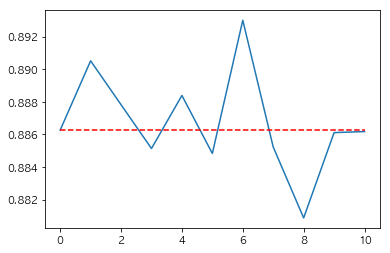

In [16]:
plt.plot(auc)
plt.plot([0, 10],[benchmark, benchmark], "red", linestyle='dashed')

# Cross Pseudo Labeling

In [17]:
from sklearn.cluster import KMeans

def crossPseudoLabeling(X_train, y_train, X_valid, y_valid, X_test, y_pred, num_class=5):

    X_test_set = []
    y_pred_set = []
    
    X_test_class = KMeans(n_clusters=num_class).fit_predict(X_test)
    
    for i in range(num_class):

        X_train_tmp = pd.concat([X_train, X_test[X_test_class != i]])
        y_train_tmp =  np.r_[y_train, y_pred[X_test_class != i]]
        
        model = lgbm_train(X_train_tmp, X_valid, y_train_tmp, y_valid, lgbm_params)
        y_pred_tmp = model.predict(X_test[X_test_class == i], num_iteration=model.best_iteration)
        
        X_test_tmp = X_test[X_test_class == i].copy()
        X_test_tmp['target'] = y_pred_tmp
        X_test_set.append(X_test_tmp)
        
        len(X_test_tmp)

    y_pred_cpl = pd.concat(X_test_set).sort_index()['target']
    
    return y_pred_cpl

In [18]:
y_pred_cpl = crossPseudoLabeling(X_train, y_train, X_valid, y_valid, X_test, y_pred, num_class=5)

[1]	valid_0's auc: 0.781331
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.798785
[3]	valid_0's auc: 0.832774
[4]	valid_0's auc: 0.849176
[5]	valid_0's auc: 0.850907
[6]	valid_0's auc: 0.856494
[7]	valid_0's auc: 0.859783
[8]	valid_0's auc: 0.859778
[9]	valid_0's auc: 0.863229
[10]	valid_0's auc: 0.865949
[11]	valid_0's auc: 0.868344
[12]	valid_0's auc: 0.870838
[13]	valid_0's auc: 0.87205
[14]	valid_0's auc: 0.872784
[15]	valid_0's auc: 0.872211
[16]	valid_0's auc: 0.872842
[17]	valid_0's auc: 0.875314
[18]	valid_0's auc: 0.876074
[19]	valid_0's auc: 0.876669
[20]	valid_0's auc: 0.87706
[21]	valid_0's auc: 0.878015
[22]	valid_0's auc: 0.879642
[23]	valid_0's auc: 0.879644
[24]	valid_0's auc: 0.88041
[25]	valid_0's auc: 0.881643
[26]	valid_0's auc: 0.883027
[27]	valid_0's auc: 0.883529
[28]	valid_0's auc: 0.88341
[29]	valid_0's auc: 0.884347
[30]	valid_0's auc: 0.884773
[31]	valid_0's auc: 0.885465
[32]	valid_0's auc: 0.886159
[33]	valid_0's auc: 0.8

[133]	valid_0's auc: 0.896149
[134]	valid_0's auc: 0.896254
[135]	valid_0's auc: 0.896206
[136]	valid_0's auc: 0.89593
[137]	valid_0's auc: 0.895977
[138]	valid_0's auc: 0.896021
[139]	valid_0's auc: 0.896185
[140]	valid_0's auc: 0.896165
[141]	valid_0's auc: 0.89627
[142]	valid_0's auc: 0.896599
[143]	valid_0's auc: 0.896567
[144]	valid_0's auc: 0.896907
[145]	valid_0's auc: 0.896934
[146]	valid_0's auc: 0.896879
[147]	valid_0's auc: 0.896873
[148]	valid_0's auc: 0.896859
[149]	valid_0's auc: 0.897162
[150]	valid_0's auc: 0.897089
[151]	valid_0's auc: 0.897223
[152]	valid_0's auc: 0.897195
[153]	valid_0's auc: 0.8971
[154]	valid_0's auc: 0.897075
[155]	valid_0's auc: 0.897037
[156]	valid_0's auc: 0.897083
[157]	valid_0's auc: 0.897003
[158]	valid_0's auc: 0.897108
[159]	valid_0's auc: 0.896845
[160]	valid_0's auc: 0.896832
[161]	valid_0's auc: 0.897237
[162]	valid_0's auc: 0.897286
[163]	valid_0's auc: 0.897364
[164]	valid_0's auc: 0.897359
[165]	valid_0's auc: 0.897355
[166]	valid_0'

[77]	valid_0's auc: 0.889775
[78]	valid_0's auc: 0.88995
[79]	valid_0's auc: 0.890068
[80]	valid_0's auc: 0.889708
[81]	valid_0's auc: 0.889649
[82]	valid_0's auc: 0.890321
[83]	valid_0's auc: 0.890552
[84]	valid_0's auc: 0.891256
[85]	valid_0's auc: 0.8912
[86]	valid_0's auc: 0.891279
[87]	valid_0's auc: 0.891343
[88]	valid_0's auc: 0.891487
[89]	valid_0's auc: 0.891248
[90]	valid_0's auc: 0.891264
[91]	valid_0's auc: 0.891264
[92]	valid_0's auc: 0.891129
[93]	valid_0's auc: 0.891085
[94]	valid_0's auc: 0.891059
[95]	valid_0's auc: 0.891021
[96]	valid_0's auc: 0.891226
[97]	valid_0's auc: 0.89159
[98]	valid_0's auc: 0.891515
[99]	valid_0's auc: 0.891676
[100]	valid_0's auc: 0.892131
[101]	valid_0's auc: 0.89205
[102]	valid_0's auc: 0.892091
[103]	valid_0's auc: 0.892614
[104]	valid_0's auc: 0.893395
[105]	valid_0's auc: 0.893474
[106]	valid_0's auc: 0.893477
[107]	valid_0's auc: 0.893501
[108]	valid_0's auc: 0.893543
[109]	valid_0's auc: 0.893612
[110]	valid_0's auc: 0.893599
[111]	va

In [19]:
roc_auc_score(y_test, y_pred_cpl)  # auc を計算する

0.88060605333245323